<img src="https://evcccpln.cscoglab.com/wp-content/uploads/2024/01/logo.webp" height=100 witdh=100/>

## EVCCCPLN Segunda Edición
#### PROFUNDIZANDO EN EL CONOCIMIENTO: MÉTODOS PARA EXPLICAR LOS MODELOS DE LENGUAJE

Practica 1.1 - Modelo de regresión logística para predecir si una oración es misógina y explicando el comportamiento del modelo con SHAP

In [ ]:
%%capture
!pip install shap

In [ ]:
%%capture
!pip install datasets

In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

pd.set_option('display.max_colwidth', None)

In [ ]:
raw_dataset   = load_dataset("glombardo/misogynistic-statements-classification")
TEXT_COLNAME  = 'text'
LABEL_COLNAME = 'label'
LABELS = ['No Misógino', 'Misógino']
RANDOM_STATE = 43

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/127 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/42 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/43 [00:00<?, ? examples/s]

In [ ]:
def tokenize_and_align_labels(examples):
  clean_examples = { TEXT_COLNAME: [ex.lower().strip() for ex in examples[TEXT_COLNAME]] }
  return clean_examples

In [ ]:
tokenized_dataset = raw_dataset.map(
    tokenize_and_align_labels,
    batched        = True,
    batch_size     = 8
    )

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

In [ ]:
train_df = pd.DataFrame(tokenized_dataset['train'])
val_df = pd.DataFrame(tokenized_dataset['validation'])
test_df = pd.DataFrame(tokenized_dataset['test'])

In [ ]:
train_df.head(10)

text  \
0                                                                                        los hombres son mejores en deportes   
1        "las mujeres tienen las mismas capacidades físicas y mentales que los hombres para participar en deportes extremos"   
2                                                cualquier persona puede cuidar de sí misma, independientemente de su género   
3                                                                 las mujeres son demasiado delicadas para trabajos manuales   
4                                                    las mujeres son demasiado emocionales para tomar decisiones importantes   
5                  "la habilidad para el combate no depende del género y todas las personas pueden ser igualmente valientes"   
6                                                                                          las mujeres no pueden ser líderes   
7  "el deporte es una actividad personal y el interés no depende del género, sino de las preferencias y gustos individuales"   
8                                             las mujeres son irracionales y están demasiado influenciadas por sus emociones   
9                                                                                 las mujeres no son buenas para la política   

   label  
0      1  
1      0  
2      0  
3      1  
4      1  
5      0  
6      1  
7      0  
8      1  
9      1

### Versión 1

In [ ]:
import re
def tokenizer(text):
  text = re.sub(r'([^a-zA-Z0-9ñÑáéíóúÁÉÍÓÚ]+)', r' \1 ', text)
  return re.sub(r'\s+', ' ', text).strip().split(" ")

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer)

X_train_tfidf = vectorizer.fit_transform(train_df[TEXT_COLNAME])
X_val_tfidf = vectorizer.transform(val_df[TEXT_COLNAME])
X_test_tfidf = vectorizer.transform(test_df[TEXT_COLNAME])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
vectorizer.get_feature_names_out()

array(['"', ',', '?', 'a', 'acceso', 'acoso', 'actividad', 'actuar',
       'acuerdan', 'agresivos', 'al', 'alguien', 'alta', 'ambiente',
       'ambos', 'amigas', 'amistad', 'amplia', 'andan', 'apariencia',
       'apoyarla', 'aprender', 'aptas', 'aspectos', 'así', 'atletas',
       'atraer', 'automóvil', 'basadas', 'basándose', 'bien', 'biológico',
       'buenas', 'búsqueda', 'cabeza', 'cada', 'caer', 'calidad',
       'cambiar', 'cambios', 'campo', 'capaces', 'capacidad',
       'capacidades', 'capacitadas', 'cargos', 'carrera', 'casarse',
       'chismosas', 'chistes', 'ciencia', 'ciencias', 'cierta', 'ciertas',
       'cocina', 'cocinar', 'combate', 'como', 'compartida',
       'competentes', 'compiten', 'completos', 'comportamiento', 'con',
       'conducir', 'conocimiento', 'construcción', 'contacto',
       'contribuir', 'controlar', 'cosas', 'cualquier', 'cuando',
       'cuidado', 'cuidar', 'culinaria', 'cumplan', 'cómo', 'de', 'debe',
       'deben', 'deberían', 'debido', '

In [ ]:
model = LogisticRegression(random_state=RANDOM_STATE)
model.fit(X_train_tfidf, train_df[LABEL_COLNAME])

LogisticRegression(random_state=43)

In [ ]:
y_pred = model.predict(X_val_tfidf)
print("Classification Report:\n", classification_report(val_df[LABEL_COLNAME], y_pred, digits=4, zero_division=0, target_names=LABELS))

Classification Report:
               precision    recall  f1-score   support

 No Misógino     0.8571    1.0000    0.9231        18
    Misógino     1.0000    0.8750    0.9333        24

    accuracy                         0.9286        42
   macro avg     0.9286    0.9375    0.9282        42
weighted avg     0.9388    0.9286    0.9289        42



In [ ]:
y_pred = model.predict(X_test_tfidf)
print("Classification Report:\n", classification_report(test_df[LABEL_COLNAME], y_pred, digits=4, zero_division=0, target_names=LABELS))

Classification Report:
               precision    recall  f1-score   support

 No Misógino     1.0000    1.0000    1.0000        23
    Misógino     1.0000    1.0000    1.0000        20

    accuracy                         1.0000        43
   macro avg     1.0000    1.0000    1.0000        43
weighted avg     1.0000    1.0000    1.0000        43



In [ ]:
idx_wrong_preds = [idx for idx, y in enumerate(zip(test_df[LABEL_COLNAME], y_pred)) if y[0] != y[1]]
idx_wrong_preds

[]

#### SHAP

In [ ]:
import shap

In [ ]:
masker = shap.maskers.Partition(data = X_train_tfidf)
explainer = shap.LinearExplainer(model, masker, nsamples=1000, seed=RANDOM_STATE)

In [ ]:
shap_values = explainer(X_test_tfidf)
X_test_array = X_test_tfidf.toarray()

Summary plot

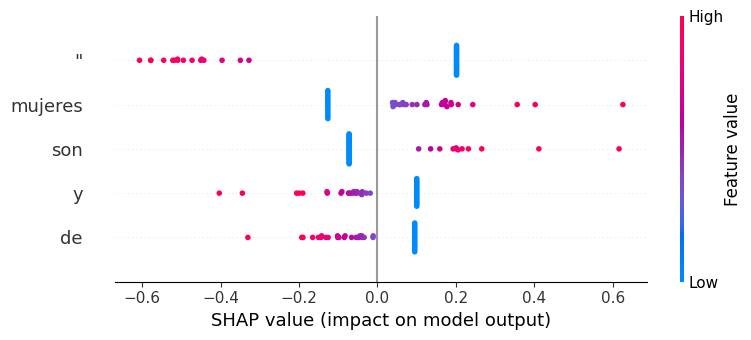

In [ ]:
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names_out(), max_display=5)

In [ ]:
shap.initjs()
shap.force_plot(base_value    = explainer.expected_value,
                shap_values   = shap_values.values,
                features      = X_test_array,
                feature_names = vectorizer.get_feature_names_out())

Predicción individual A

In [ ]:
shap.initjs()
ind = 0
shap.force_plot(base_value    = explainer.expected_value,
                shap_values   = shap_values.values[ind, :],
                features      = X_test_array[ind, :],
                feature_names = vectorizer.get_feature_names_out())

In [ ]:
print(test_df['text'].iloc[ind])

"la habilidad de conducir no depende del género y las mujeres pueden ser tan hábiles al volante como los hombres"


Predicción Individual B

In [ ]:
shap.initjs()
ind = 7
shap.force_plot(base_value    = explainer.expected_value,
                shap_values   = shap_values.values[ind, :],
                features      = X_test_array[ind, :],
                feature_names = vectorizer.get_feature_names_out())

In [ ]:
test_df[TEXT_COLNAME].iloc[ind], test_df[LABEL_COLNAME].iloc[ind]

('las mujeres son demasiado sensibles para trabajar en ambientes profesionales',
 1)

### Versión 2

In [ ]:
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(train_df[TEXT_COLNAME])
X_val_tfidf = vectorizer.transform(val_df[TEXT_COLNAME])
X_test_tfidf = vectorizer.transform(test_df[TEXT_COLNAME])

In [ ]:
vectorizer.get_feature_names_out()

array(['acceso', 'acoso', 'actividad', 'actuar', 'acuerdan', 'agresivos',
       'al', 'alguien', 'alta', 'ambiente', 'ambos', 'amigas', 'amistad',
       'amplia', 'andan', 'apariencia', 'apoyarla', 'aprender', 'aptas',
       'aspectos', 'así', 'atletas', 'atraer', 'automóvil', 'basadas',
       'basándose', 'bien', 'biológico', 'buenas', 'búsqueda', 'cabeza',
       'cada', 'caer', 'calidad', 'cambiar', 'cambios', 'campo',
       'capaces', 'capacidad', 'capacidades', 'capacitadas', 'cargos',
       'carrera', 'casarse', 'chismosas', 'chistes', 'ciencia',
       'ciencias', 'cierta', 'ciertas', 'cocina', 'cocinar', 'combate',
       'como', 'compartida', 'competentes', 'compiten', 'completos',
       'comportamiento', 'con', 'conducir', 'conocimiento',
       'construcción', 'contacto', 'contribuir', 'controlar', 'cosas',
       'cualquier', 'cuando', 'cuidado', 'cuidar', 'culinaria', 'cumplan',
       'cómo', 'de', 'debe', 'deben', 'deberían', 'debido', 'debilidad',
       'decisio

In [ ]:
model = LogisticRegression(random_state=RANDOM_STATE)
model.fit(X_train_tfidf, train_df[LABEL_COLNAME])

LogisticRegression(random_state=43)

In [ ]:
y_pred = model.predict(X_val_tfidf)
print("Classification Report:\n", classification_report(val_df[LABEL_COLNAME], y_pred, digits=4, zero_division=0, target_names=LABELS))

Classification Report:
               precision    recall  f1-score   support

 No Misógino     0.8182    1.0000    0.9000        18
    Misógino     1.0000    0.8333    0.9091        24

    accuracy                         0.9048        42
   macro avg     0.9091    0.9167    0.9045        42
weighted avg     0.9221    0.9048    0.9052        42



In [ ]:
y_pred = model.predict(X_test_tfidf)
print("Classification Report:\n", classification_report(test_df[LABEL_COLNAME], y_pred, digits=4, zero_division=0, target_names=LABELS))

Classification Report:
               precision    recall  f1-score   support

 No Misógino     0.8800    0.9565    0.9167        23
    Misógino     0.9444    0.8500    0.8947        20

    accuracy                         0.9070        43
   macro avg     0.9122    0.9033    0.9057        43
weighted avg     0.9100    0.9070    0.9065        43



In [ ]:
idx_wrong_preds = [idx for idx, y in enumerate(zip(test_df[LABEL_COLNAME], y_pred)) if y[0] != y[1]]
idx_wrong_preds

[2, 4, 28, 40]

#### SHAP

In [ ]:
import shap

In [ ]:
masker = shap.maskers.Independent(data = X_train_tfidf)
explainer = shap.LinearExplainer(model, masker, nsamples=1000, seed=RANDOM_STATE)

In [ ]:
shap_values = explainer(X_test_tfidf)
X_test_array = X_test_tfidf.toarray()

Summary plot

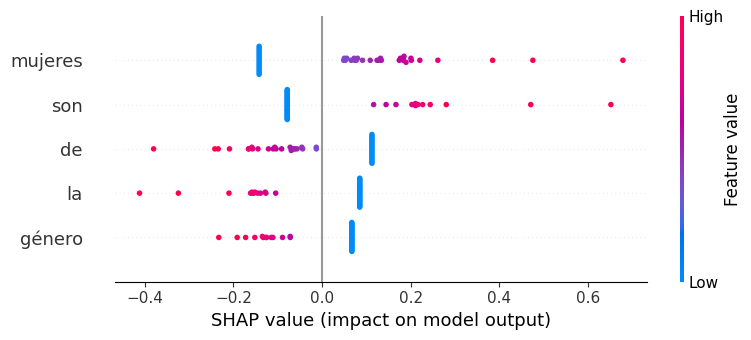

In [ ]:
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names_out(), max_display=5)

In [ ]:
shap.initjs()
shap.force_plot(base_value    = explainer.expected_value,
                shap_values   = shap_values.values,
                features      = X_test_array,
                feature_names = vectorizer.get_feature_names_out())

Predicción individual A

In [ ]:
shap.initjs()
ind = 0
shap.force_plot(base_value    = explainer.expected_value,
                shap_values   = shap_values.values[ind, :],
                features      = X_test_array[ind, :],
                feature_names = vectorizer.get_feature_names_out())

In [ ]:
print(test_df['text'].iloc[ind])

"la habilidad de conducir no depende del género y las mujeres pueden ser tan hábiles al volante como los hombres"


Predicción Individual B

In [ ]:
shap.initjs()
ind = 28
shap.force_plot(base_value    = explainer.expected_value,
                shap_values   = shap_values.values[ind, :],
                features      = X_test_array[ind, :],
                feature_names = vectorizer.get_feature_names_out())

In [ ]:
test_df[TEXT_COLNAME].iloc[ind], test_df[LABEL_COLNAME].iloc[ind]

('las mujeres no tienen el valor para el combate', 1)